### Data Dictionary

Imagine that you are a medical researcher compiling data for a study. You have collected data about a set of patients, all of whom suffered from the same illness. During their course of treatment, each patient responded to one of 5 medications, Drug A, Drug B, Drug c, Drug x and y. 

Part of your job is to build a model to find out which drug might be appropriate for a future patient with the same illness. The feature sets of this dataset are Age, Sex, Blood Pressure, and Cholesterol of patients, and the target is the drug that each patient responded to.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.5)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score


import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer

from tpot import TPOTClassifier, TPOTRegressor
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

### Data Exploration

In [2]:
df = pd.read_csv("drug200.csv")

In [3]:
df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [5]:
df.describe(include='all')

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
count,200.000000,200,200,200,200.000000,200
unique,NaN,2,3,2,NaN,5
top,NaN,M,HIGH,HIGH,NaN,drugY
freq,NaN,104,77,103,NaN,91
mean,44.315000,NaN,NaN,NaN,16.084485,NaN
std,16.544315,NaN,NaN,NaN,7.223956,NaN
min,15.000000,NaN,NaN,NaN,6.269000,NaN
25%,31.000000,NaN,NaN,NaN,10.445500,NaN
50%,45.000000,NaN,NaN,NaN,13.936500,NaN
75%,58.000000,NaN,NaN,NaN,19.380000,NaN


In [6]:
df.shape

(200, 6)

In [7]:
df.columns

Index(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K', 'Drug'], dtype='object')

### Data Visualization

### Univariate Data Exploration

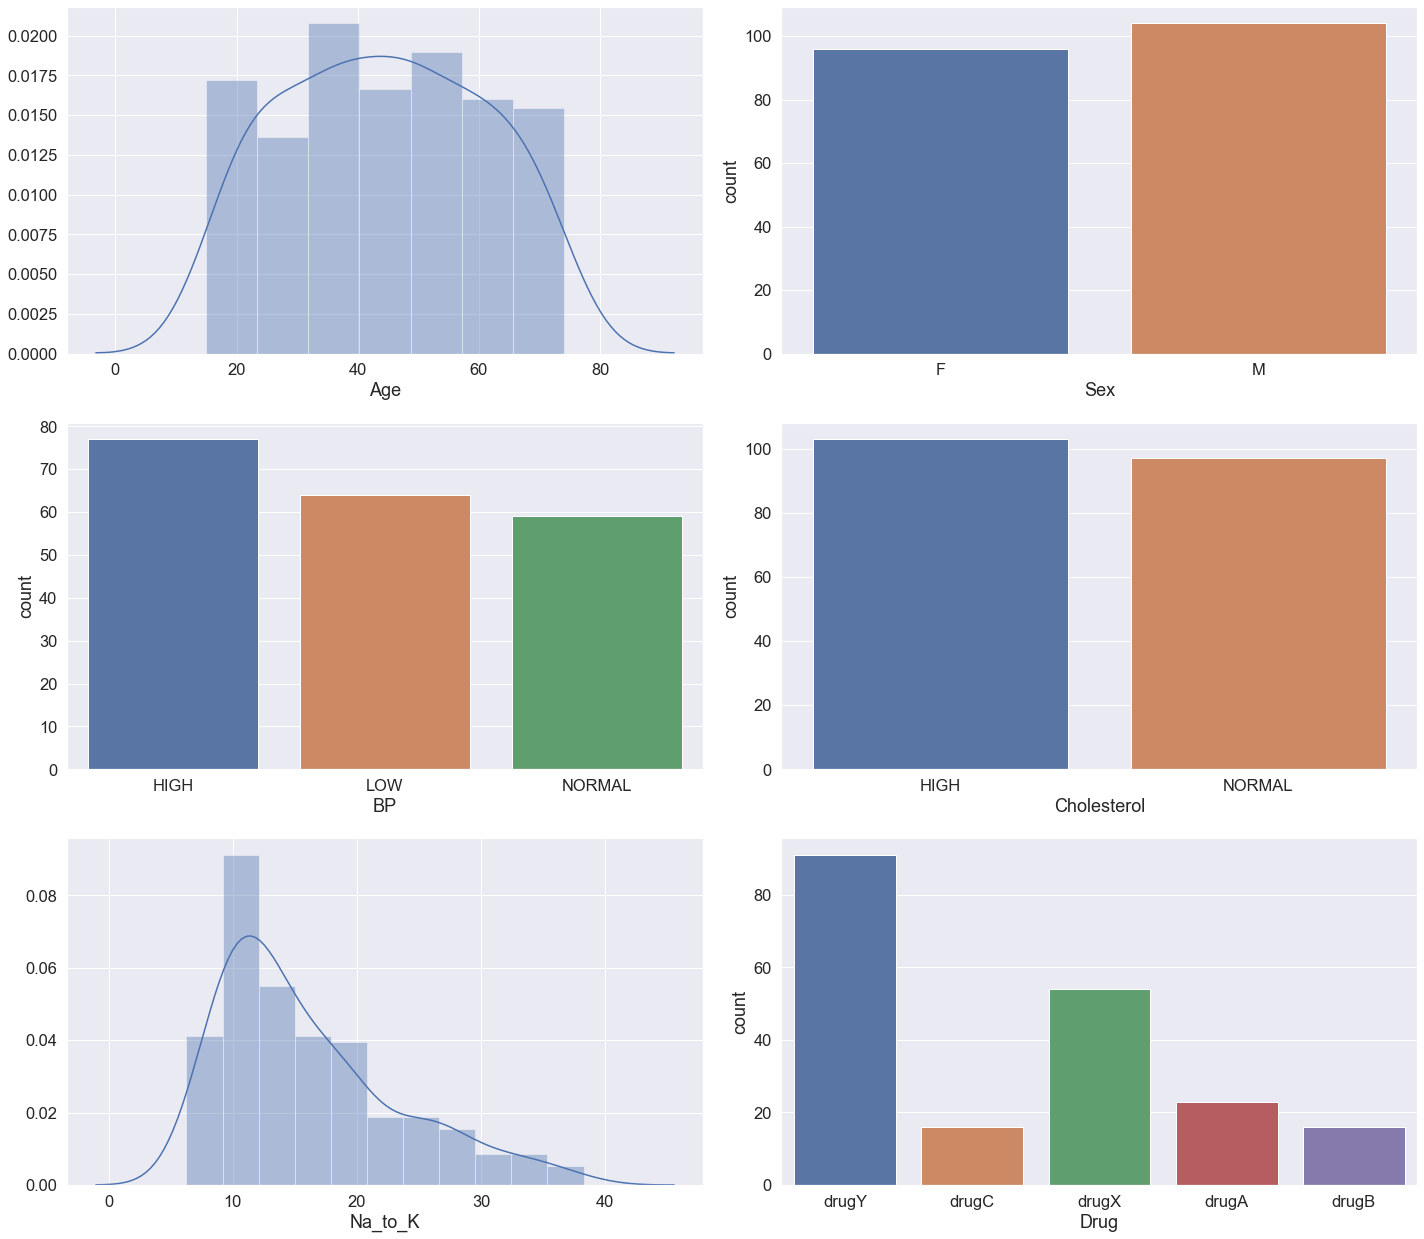

In [8]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
sns.distplot(df.Age)
plt.subplot(7,2,2)
sns.countplot(df.Sex)
plt.subplot(7,2,3)
sns.countplot(df.BP)
plt.subplot(7,2,4)
sns.countplot(df.Cholesterol)
plt.subplot(7,2,5)
sns.distplot(df.Na_to_K)
plt.subplot(7,2,6)
sns.countplot(df.Drug)
# plt.subplot(7,2,7)
# sns.countplot()
# plt.subplot(7,2,8)
# sns.countplot()
# plt.subplot(7,2,9)
# sns.countplot()
# plt.subplot(7,2,10)
# sns.countplot()
# plt.subplot(7,2,11)
# sns.countplot()
# plt.subplot(7,2,12)
# sns.countplot()
# plt.subplot(7,2,13)
# sns.countplot()
# plt.subplot(7,2,14)
# sns.countplot()

plt.tight_layout()
plt.show()

### Bivariate Data Exploration

In [9]:
df.corr()

,Age,Na_to_K
Age,1.000000,-0.063119
Na_to_K,-0.063119,1.000000


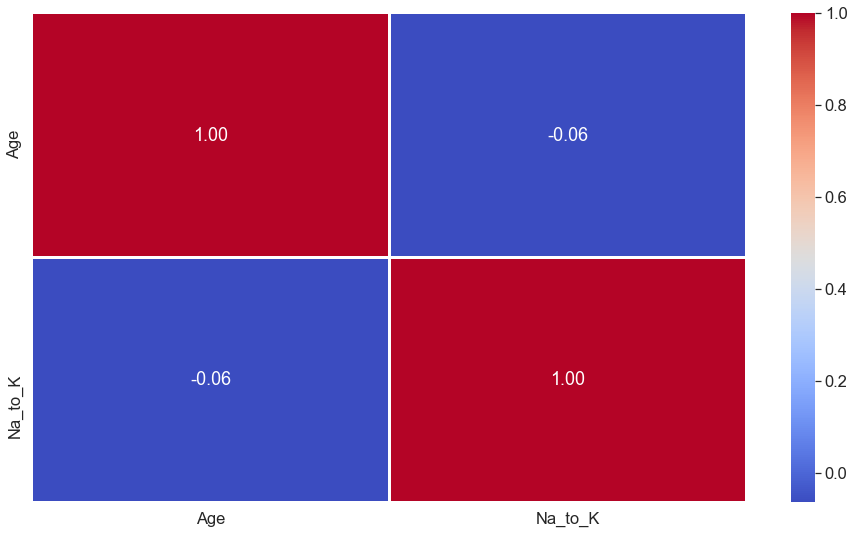

In [10]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

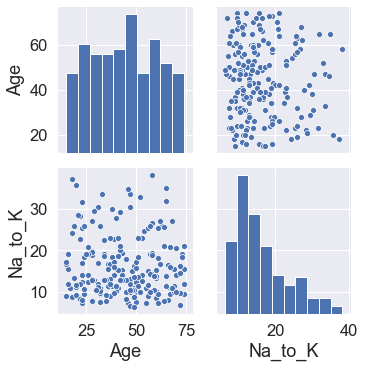

In [11]:
sns.pairplot(df)
plt.show()

### Data Preprocessing

### Treat Missing Values

In [12]:
df.isnull().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

### Treat Duplicate Values

In [13]:
df.duplicated(keep='first').sum()

0

### Treat Outliers

In [14]:
df.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


### Treat Data Types

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


### Drop unwanted features

In [16]:
df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


In [17]:
df.columns

Index(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K', 'Drug'], dtype='object')

In [18]:
df.shape

(200, 6)

### Create and save processed dataset

In [19]:
#df.to_csv("drugtrain.csv",index=False)

In [20]:
X = df.iloc[:,0:5]
y = df.iloc[:,5]

In [21]:
X

,Age,Sex,BP,Cholesterol,Na_to_K
0,23,F,HIGH,HIGH,25.355
1,47,M,LOW,HIGH,13.093
2,47,M,LOW,HIGH,10.114
3,28,F,NORMAL,HIGH,7.798
4,61,F,LOW,HIGH,18.043
...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567
196,16,M,LOW,HIGH,12.006
197,52,M,NORMAL,HIGH,9.894
198,23,M,NORMAL,NORMAL,14.020


In [22]:
X2 = pd.get_dummies(X,columns=['Sex', 'BP', 'Cholesterol'],drop_first=True)

In [23]:
X2

,Age,Na_to_K,Sex_M,BP_LOW,BP_NORMAL,Cholesterol_NORMAL
0,23,25.355,0,0,0,0
1,47,13.093,1,1,0,0
2,47,10.114,1,1,0,0
3,28,7.798,0,0,1,0
4,61,18.043,0,1,0,0
...,...,...,...,...,...,...
195,56,11.567,0,1,0,0
196,16,12.006,1,1,0,0
197,52,9.894,1,0,1,0
198,23,14.020,1,0,1,1


In [24]:
y

0      drugY
1      drugC
2      drugC
3      drugX
4      drugY
       ...  
195    drugC
196    drugC
197    drugX
198    drugX
199    drugX
Name: Drug, Length: 200, dtype: object

In [25]:
y.value_counts()

drugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: Drug, dtype: int64

In [26]:
encoder = LabelEncoder()

In [27]:
y2 = encoder.fit_transform(y)

In [28]:
y2

array([4, 2, 2, 3, 4, 3, 4, 2, 4, 4, 2, 4, 4, 4, 3, 4, 3, 0, 2, 4, 4, 4,
       4, 4, 4, 4, 4, 3, 4, 4, 3, 1, 3, 4, 3, 3, 0, 3, 3, 3, 4, 1, 4, 3,
       3, 3, 0, 2, 4, 4, 4, 3, 4, 4, 1, 2, 1, 4, 3, 4, 4, 0, 4, 3, 1, 4,
       0, 3, 4, 4, 1, 4, 3, 4, 4, 4, 0, 4, 0, 3, 1, 3, 2, 0, 2, 1, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 0, 0, 2, 3, 4, 3, 3, 4, 1, 4,
       0, 3, 3, 3, 3, 4, 3, 3, 0, 4, 4, 4, 4, 4, 1, 4, 4, 3, 4, 3, 4, 4,
       3, 4, 4, 3, 1, 0, 1, 3, 0, 4, 1, 4, 0, 3, 3, 0, 3, 2, 0, 1, 3, 3,
       4, 2, 0, 4, 2, 3, 3, 1, 3, 4, 4, 4, 4, 3, 4, 0, 3, 3, 4, 4, 0, 4,
       0, 4, 4, 4, 4, 3, 3, 4, 4, 4, 1, 0, 4, 4, 4, 0, 4, 2, 4, 2, 2, 3,
       3, 3])

In [29]:
y2 = pd.DataFrame(y2,columns=['Drug'])

In [30]:
y2

,Drug
0,4
1,2
2,2
3,3
4,4
...,...
195,2
196,2
197,3
198,3


### Treat Imbalance Data

In [31]:
y2['Drug'].value_counts()

4    91
3    54
0    23
2    16
1    16
Name: Drug, dtype: int64

In [32]:
ros = RandomOverSampler(sampling_strategy='all',random_state=0)

In [33]:
new_X, new_y = ros.fit_resample(X2, y2)

In [34]:
new_y['Drug'].value_counts()

4    91
3    91
2    91
1    91
0    91
Name: Drug, dtype: int64

In [35]:
new_X

,Age,Na_to_K,Sex_M,BP_LOW,BP_NORMAL,Cholesterol_NORMAL
0,23,25.355,0,0,0,0
1,47,13.093,1,1,0,0
2,47,10.114,1,1,0,0
3,28,7.798,0,0,1,0
4,61,18.043,0,1,0,0
...,...,...,...,...,...,...
450,61,9.443,1,0,1,0
451,49,13.598,1,1,0,1
452,51,13.597,0,0,1,0
453,18,8.750,0,0,1,1


In [36]:
X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.2, random_state=0)

In [37]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((364, 6), (91, 6), (364, 1), (91, 1))

### Feature Scaling

In [38]:
X_train

,Age,Na_to_K,Sex_M,BP_LOW,BP_NORMAL,Cholesterol_NORMAL
49,28,19.796,0,1,0,0
52,62,27.183,1,1,0,1
74,31,17.069,1,0,0,1
26,31,30.366,1,0,0,0
45,66,8.107,0,0,1,1
...,...,...,...,...,...,...
323,74,9.567,1,0,0,0
192,72,16.310,1,1,0,0
117,40,10.103,0,0,1,0
47,68,10.291,1,1,0,0


In [39]:
scaler = StandardScaler()

In [40]:
X_train_scaled = scaler.fit_transform(X_train)

In [41]:
X_test_scaled = scaler.transform(X_test)

In [42]:
X_train_scaled

array([[-1.13020914,  1.17827917, -1.11665285,  1.46216655, -0.49656353,
        -0.80903983],
       [ 0.92104006,  2.50302287,  0.89553347,  1.46216655, -0.49656353,
         1.23603308],
       [-0.94921656,  0.68923408,  0.89553347, -0.68391661, -0.49656353,
         1.23603308],
       ...,
       [-0.40623883, -0.56000981, -1.11665285, -0.68391661,  2.013841  ,
        -0.80903983],
       [ 1.28302521, -0.52629493,  0.89553347,  1.46216655, -0.49656353,
        -0.80903983],
       [-0.46656969,  0.71721026, -1.11665285, -0.68391661,  2.013841  ,
         1.23603308]])

In [43]:
X_test_scaled

array([[ 0.01607718, -0.55803713,  0.89553347,  1.46216655, -0.49656353,
        -0.80903983],
       [-0.52690055,  2.98579126, -1.11665285,  1.46216655, -0.49656353,
         1.23603308],
       [ 0.61938577, -0.58834465, -1.11665285, -0.68391661, -0.49656353,
         1.23603308],
       [ 1.28302521, -0.52629493,  0.89553347,  1.46216655, -0.49656353,
        -0.80903983],
       [ 1.10203264,  0.09743035, -1.11665285,  1.46216655, -0.49656353,
         1.23603308],
       [ 0.49872405, -0.40327148, -1.11665285, -0.68391661, -0.49656353,
        -0.80903983],
       [-0.22524626,  0.38562083,  0.89553347,  1.46216655, -0.49656353,
        -0.80903983],
       [-1.85417944,  1.03678428,  0.89553347, -0.68391661, -0.49656353,
         1.23603308],
       [-0.94921656, -0.24294647,  0.89553347, -0.68391661, -0.49656353,
         1.23603308],
       [ 0.1367389 , -1.24757815,  0.89553347, -0.68391661, -0.49656353,
         1.23603308],
       [ 0.37806233, -0.13104176, -1.11665285, -0.

In [44]:
y_train

,Drug
49,4
52,4
74,4
26,4
45,3
...,...
323,1
192,4
117,3
47,2


0 = Drug A ;  1 = Drug B, 2 = Drug C, 3 = Drug X, 4 = Drug Y

### Model Training

### Using XGBoost

In [45]:
dtrain = xgb.DMatrix(data=X_train_scaled,label=y_train)
dtest = xgb.DMatrix(data=X_test_scaled)

In [46]:
params = {'n_estimators':100,
          'objective': 'multi:softmax',
          'num_class': 5,
          'seed': 0,
          'eval_metric':'merror'}

In [47]:
#evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [48]:
xgbmodel = xgb.train(params=params,dtrain=dtrain,num_boost_round=10)

In [49]:
y_pred = xgbmodel.predict(dtest)

In [50]:
y_pred

array([2., 4., 1., 2., 3., 1., 4., 4., 0., 0., 1., 2., 0., 0., 0., 2., 4.,
       2., 2., 0., 4., 4., 1., 2., 0., 2., 1., 1., 0., 0., 1., 0., 1., 4.,
       2., 2., 2., 1., 3., 4., 4., 3., 1., 2., 4., 3., 4., 1., 4., 3., 3.,
       0., 3., 0., 0., 4., 0., 0., 3., 4., 1., 4., 1., 0., 1., 3., 1., 0.,
       2., 2., 0., 1., 3., 4., 1., 4., 2., 0., 3., 4., 1., 3., 3., 2., 3.,
       0., 3., 4., 0., 4., 2.], dtype=float32)

### Model Evaluation

In [51]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[21,  0,  0,  0,  0],
       [ 0, 18,  0,  0,  0],
       [ 0,  0, 17,  0,  0],
       [ 0,  0,  0, 15,  2],
       [ 0,  0,  0,  0, 18]], dtype=int64)

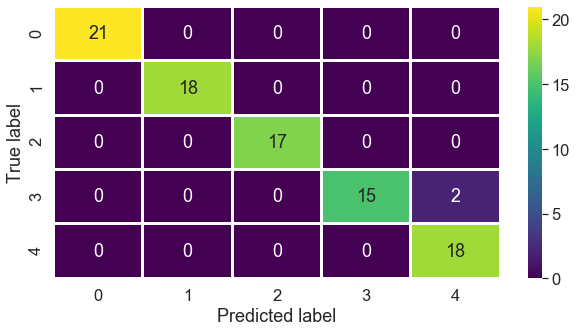

In [52]:
fig , ax = plt.subplots(figsize=(10,5))
sns.heatmap(cm, annot=True,fmt='.4g',linewidths=2, cmap='viridis')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [53]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        17
           3       1.00      0.88      0.94        17
           4       0.90      1.00      0.95        18

    accuracy                           0.98        91
   macro avg       0.98      0.98      0.98        91
weighted avg       0.98      0.98      0.98        91



### Model Tuning

### Using RandomSearchCV

In [61]:
model = XGBClassifier(random_state=0, n_estimators=100, objective='multi:softmax')

In [62]:
parameters = {'max_depth': np.arange(3,10,1),
              'learning rate': np.arange(0.05,0.3,0.03),
              'n_estimators':np.arange(100,1000,100),
              'min_child_weight': np.arange(1,4,1),
              'gamma':np.arange(0,50,2),
              'subsample':np.arange(0.5,0.9,0.1),
              'colsample_bytree':np.arange(0.5,0.9,0.1)
             }

In [63]:
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, cv = 5, n_iter = 50, 
                           n_jobs=-1, scoring='accuracy')

In [64]:
randm.fit(X2, y2)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='multi:softmax',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scal...
       34, 36, 38, 40, 42, 44, 46, 48]),
                                        'learning rate': array([0.05, 0.08, 0.11, 0.14, 0.17, 0.2 , 0.23, 0.26, 0.29]),
                

In [65]:
randm.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=4,
              learning rate=0.05, learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=3, missing=None, n_estimators=300,
              n_jobs=1, nthread=None, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.7, verbosity=1)

In [66]:
randm.best_score_

0.9800000000000001

In [67]:
randm.best_params_

{'subsample': 0.7,
 'n_estimators': 300,
 'min_child_weight': 3,
 'max_depth': 6,
 'learning rate': 0.05,
 'gamma': 4,
 'colsample_bytree': 0.6}

### Save the Model

In [69]:
import pickle
from pickle import dump
filename = 'modeldrug.sav'
dump(xgbmodel,open(filename,'wb'))

### Load the Model

In [ ]:
loaded_model = load(open(filename,'rb'))

In [ ]:
loaded_model